# **1. Import Library**

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

# **2. Memuat Dataset dari Hasil Clustering**

In [2]:
data = pd.read_csv('dataset_klasifikasi.csv')

In [3]:
data.head(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,...,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score,Cluster
0,23,84,Low,High,No,7,73,Low,Yes,0,...,Medium,Public,Positive,3,No,High School,Near,Male,67,4
1,19,64,Low,Medium,No,8,59,Low,Yes,2,...,Medium,Public,Negative,4,No,College,Moderate,Female,61,2
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,...,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74,2
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,...,Medium,Public,Negative,4,No,High School,Moderate,Male,71,2
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,...,High,Public,Neutral,4,No,College,Near,Female,70,1


In [4]:
data.shape

(6607, 21)

# **3. Data Splitting**

In [5]:
# definisikan data fitur dan target
y = data['Cluster']
X = data.drop(['Cluster'], axis=1)

In [6]:
# membagi data menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)

### *Pre-processing*

#### *Missing value*

In [7]:
# periksa apakah ada missing value
display(X_train.isnull().sum())

display(X_test.isnull().sum())

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               63
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      67
Distance_from_Home            56
Gender                         0
Exam_Score                     0
dtype: int64

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               15
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      23
Distance_from_Home            11
Gender                         0
Exam_Score                     0
dtype: int64

In [8]:
# kolom dengan missing value
missing_value_cols_train = [col for col in X_train.columns if X_train[col].isnull().sum() > 0]
missing_value_cols_test = [col for col in X_test.columns if X_test[col].isnull().sum() > 0]

print(missing_value_cols_train)
print(missing_value_cols_test)

['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']
['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']


Ketiga kolom ini bertipe kategorik, sehingga **missing value akan diisi menggunakan modus**

In [9]:
# mengisi missing value dengan modus
for col in missing_value_cols_train:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])

for col in missing_value_cols_test:
    X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

In [10]:
# periksa kembali apakah masih ada missing value
display(X_train.isnull().sum())

display(X_test.isnull().sum())

Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64

Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64

#### Normalisasi

In [11]:
# list yang berisikan kolom-kolom numerik
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

print(numerical_cols)

['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']


In [12]:
scl = MinMaxScaler()

# hanya fit ke data train
scl.fit(X_train[numerical_cols])

X_train[numerical_cols] = scl.transform(X_train[numerical_cols])
X_test[numerical_cols] = scl.transform(X_test[numerical_cols])

#### *Label encoding*

In [13]:
# list yang berisikan kolom-kolom kategorik
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

print(categorical_cols)

['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


In [14]:
le = LabelEncoder()

# labeling untuk setiap kolom kategorik
for col in categorical_cols:
    # hanya fit ke data train
    le.fit(X_train[col])

    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [15]:
X_train.head(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
3439,0.488372,0.050,0,2,0,0.833333,0.02,2,1,0.250,1,2,1,1,0.333333,0,1,2,1,0.177778
5045,0.581395,0.950,0,1,0,0.000000,0.76,1,1,0.125,2,0,1,1,0.166667,0,0,1,0,0.377778
4172,0.372093,0.675,2,2,1,0.833333,0.06,1,1,0.375,1,2,1,2,0.500000,0,2,1,0,0.266667
3722,0.209302,0.275,2,1,0,1.000000,0.06,1,1,0.500,0,2,0,2,0.500000,0,1,2,0,0.155556
3468,0.372093,0.800,2,2,0,0.500000,0.98,2,1,0.125,2,2,1,1,0.333333,0,0,0,0,0.288889


In [16]:
X_test.head(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
509,0.325581,0.950,1,0,1,0.666667,0.38,1,1,0.250,1,2,1,1,0.666667,0,1,1,0,0.288889
436,0.674419,0.650,2,1,1,0.666667,0.04,2,1,0.250,2,2,1,0,0.333333,1,0,1,0,0.288889
4868,0.465116,0.025,2,2,1,0.333333,0.86,1,1,0.375,2,0,0,1,0.500000,0,1,2,0,0.222222
4468,0.465116,0.475,2,2,1,0.500000,0.98,2,1,0.250,1,2,1,2,0.333333,0,2,2,1,0.311111
6601,0.441860,0.575,2,1,0,0.333333,0.02,1,1,0.250,2,2,1,1,0.666667,0,1,1,0,0.222222


#### SMOTE

In [17]:
# menyeimbangkan kelas/label pada data train menggunakan smote
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Digunakan dua algoritma klasifikasi yaitu Random Forest dan AdaBoost

In [18]:
# fit model random forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [19]:
# fit model adaboost
ada = AdaBoostClassifier(random_state=42, algorithm='SAMME')
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

**Penjelasan algoritma yang digunakan** <br>

**1. Random Forest** <br>

Random Forest adalah algoritma ensemble learning yang menggunakan banyak pohon keputusan (decision trees) untuk membuat prediksi. Setiap pohon dilatih pada subset data yang dipilih secara acak (dengan bootstrap sampling), dan setiap split dalam pohon dibuat berdasarkan subset fitur yang dipilih secara acak. Hasil akhir dari Random Forest adalah rata-rata atau mayoritas voting dari prediksi semua pohon.

Kelebihan:
- Karena menggunakan banyak pohon dan teknik bagging, Random Forest cenderung tidak overfit.
- Random Forest dapat menangani data yang hilang dengan baik.
- Random Forest dapat memberikan informasi tentang pentingnya setiap fitur dalam prediksi.

Kekurangan:
- Karena menggunakan banyak pohon, Random Forest bisa menjadi lambat dan memakan banyak memori.
- Meskipun bisa memberikan feature importance, modelnya sendiri sulit diinterpretasikan secara detail.

**2. AdaBoost** <br>

AdaBoost (Adaptive Boosting) adalah algoritma ensemble learning yang menggabungkan beberapa model lemah menjadi model yang kuat. Setiap model lemah dilatih secara berurutan, dengan model berikutnya mencoba memperbaiki kesalahan yang dibuat oleh model sebelumnya.

Kelebihan:
- AdaBoost dapat meningkatkan akurasi dengan menggabungkan beberapa model lemah.
- Cocok untuk dataset dengan kelas yang tidak seimbang.
- Dapat digunakan dengan berbagai base estimator (misalnya, Decision Tree, SVM).

Kekurangan:
- Karena fokus pada kesalahan prediksi, AdaBoost bisa menjadi sensitif terhadap noise dan outlier.
- Jika base estimator terlalu kompleks, AdaBoost bisa overfit.

**Alasan penggunaan** <br>
- Random Forest dipilih karena robust dan dapat menangani multi-kelas dengan baik.
- AdaBoost cocok untuk meningkatkan akurasi.

## **b. Evaluasi Model Klasifikasi**

In [20]:
# fungsi evaluasi model
def evaluate_classification(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') 
    recall = recall_score(y_test, y_pred, average='weighted')        
    f1 = f1_score(y_test, y_pred, average='weighted')    

    print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f} \n")
    
    print("Confusion Matrix")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

    return 

### Evaluasi model Random Forest

Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1-score: 1.000 

Confusion Matrix


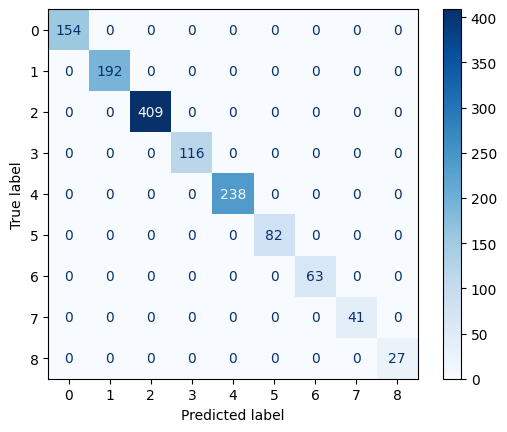

In [21]:
evaluate_classification(y_test, rf_pred)

- Model Random Forest menghasilkan akurasi, precision, recall, dan F1-score sempurna (1.00).
- Confusion matrix menunjukkan bahwa tidak ada kesalahan prediksi (semua sampel test diprediksi dengan benar).

### Evaluasi model AdaBoost

Accuracy: 0.685, Precision: 0.642, Recall: 0.685, F1-score: 0.648 

Confusion Matrix


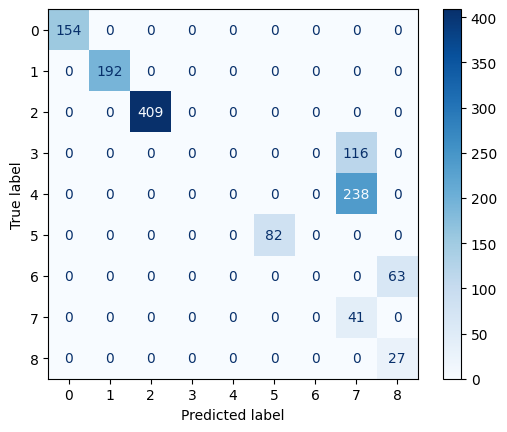

In [22]:
evaluate_classification(y_test, ada_pred)

- Model AdaBoost menghasilkan akurasi, precision, recall, dan F1-score sekitar 64-68%. Ini menunjukkan bahwa model memiliki performa yang kurang baik dalam memprediksi kelas target.
- Confusion matrix menunjukkan bahwa ada kesalahan prediksi yang signifikan untuk beberapa kelas, terutama:
  - Kelas 3: Semua sampel (116) salah diprediksi sebagai kelas 7.
  - Kelas 4: Semua sampel (238) salah diprediksi sebagai kelas 7.
  - Kelas 6: Semua sampel (63) salah diprediksi sebagai kelas 8.


### Ringkasan hasil evaluasi

In [23]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME', random_state=42)
}

In [24]:
def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = []
    
    for name, model in models.items():
        # Latih model
        model.fit(X_train, y_train)
        
        # Prediksi pada data uji
        y_pred = model.predict(X_test)
        
        # Hitung akurasi dan F1 weighted
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        
        # Simpan hasil evaluasi
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Weighted': f1,
            'Precision': precision,
            'Recall': recall
        })
    
    # Buat DataFrame dari hasil evaluasi
    results_df = pd.DataFrame(results)
    
    return results_df

In [25]:
evaluation_results = evaluate_models(X_train, X_test, y_train, y_test, models)

In [26]:
evaluation_results.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,F1 Weighted,Precision,Recall
0,Random Forest,1.000000,1.000000,1.000000,1.000000
1,AdaBoost,0.684569,0.648391,0.642478,0.684569


**Analisis hasil evaluasi**
- Random Forest adalah model terbaik dalam hal performa, dengan akurasi, precision, recall, dan F1-score sempurna (100%). 
- AdaBoost memiliki performa yang cukup rendah dengan akurasi dan F1-score di bawah 70%. Karena performa model ini tergolong cukup rendah, maka akan dilakukan *hyperparameter tuning* menggunakan GridSearchCV

## **c. Tuning Model Klasifikasi (Optional)**

### Hyperparameter tuning menggunakan GridSearchCV pada model AdaBoost

In [27]:
ada_param_grid = {
    'n_estimators': [50, 100, 200],  # jumlah estimator (boosting stages)
    'learning_rate': [0.01, 0.1, 1.0],  # learning rate
    'estimator': [DecisionTreeClassifier()] # base estimator
}

AdaBoostClassifier()
ada_grid_search = GridSearchCV(
    estimator=ada,
    param_grid=ada_param_grid,
    cv=5,  # 5-fold CV
    scoring='accuracy',  
    n_jobs=-1  
)

ada_grid_search.fit(X_train, y_train)

print("AdaBoost - Best Parameters:", ada_grid_search.best_params_)
print("AdaBoost - Best CV Accuracy:", ada_grid_search.best_score_)

AdaBoost - Best Parameters: {'estimator': DecisionTreeClassifier(), 'learning_rate': 0.01, 'n_estimators': 50}
AdaBoost - Best CV Accuracy: 1.0


- Ditemukan parameter terbaik untuk model AdaBoost yaitu `'estimator': DecisionTreeClassifier(), 'learning_rate': 0.01, 'n_estimators': 50`. 
- Model dengan parameter terbaik menghasilkan akurasi CV sempurna (100%)

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1-score: 1.000 

Confusion Matrix


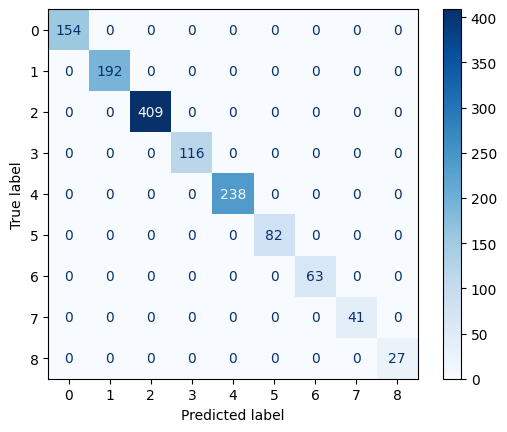

In [28]:
# Evaluasi model AdaBoost terbaik pada data test
ada_best_model = ada_grid_search.best_estimator_
y_pred_ada = ada_best_model.predict(X_test)
evaluate_classification(y_test, y_pred_ada)

- Model AdaBoost dengan parameter terbaik menghasilkan akurasi, precision, recall, dan F1-score sempurna (1.00).
- Confusion matrix menunjukkan bahwa tidak ada kesalahan prediksi (semua data test diprediksi dengan benar).

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

**Perbandingan Sebelum dan Sesudah *Hyperparameter Tuning*** <br>

Sebelum *hyperparameter tuning*, performa AdaBoost adalah:
- Accuracy: 0.68
- Precision: 0.64
- Recall: 0.68
- F1-score: 0.65

Setelah *hyperparameter tuning*, performa AdaBoost meningkat secara signifikan:
- Accuracy: 1.00 
- Precision: 1.00 
- Recall: 1.00 
- F1-score: 1.00 

**Identifikasi kelemahan model** <br>

- Sebelum Tuning
  - Precision dan recall rendah (0.64 dan 0.68) yang menunjukkan bahwa model sering melakukan kesalahan prediksi, terutama untuk beberapa kelas. 
  - Performa yang rendah sebelum tuning menunjukkan bahwa model mungkin **underfitting**, artinya model tidak cukup kompleks untuk menangkap pola dalam data.

- Setelah tuning tidak ada kelemahan yang terlihat, model menunjukkan performa sempurna (100%) tanpa kesalahan prediksi